In [1]:
import xml.etree.ElementTree as ET
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
import random
import os
from pathlib import Path

In [ ]:
!pip install bioc

In [3]:
from bioc import biocxml

def parse_bioc_xml_to_spacy(path):
    docs = []

    with open(path, 'r') as fp:
        collection = biocxml.load(fp)

    for doc in collection.documents:
        for passage in doc.passages:
            passage_text = passage.text
            passage_offset = passage.offset  # Typically 0 for title, 55+ for abstract
            entities = []

            for ann in passage.annotations:
                loc = ann.locations[0]
                start = loc.offset - passage_offset
                end = start + loc.length
                label = ann.infons["type"]

                # Safety check: prevent index errors
                if start >= 0 and end <= len(passage_text):
                    entities.append((start, end, label))
                else:
                    print(f"[WARNING] Skipping annotation out of bounds: {start}-{end} in passage: {passage_text}")

            docs.append((passage_text, {"entities": entities}))

    return docs

In [4]:
MODEL_OUTPUT_DIR = "/kaggle/working/disease_ner_model"

In [5]:
train_data = parse_bioc_xml_to_spacy('/kaggle/input/bc5dr-full/CDR_TrainingSet.BioC.xml')
val_data = parse_bioc_xml_to_spacy('/kaggle/input/bc5dr-full/CDR_DevelopmentSet.BioC.xml')
test_data = parse_bioc_xml_to_spacy('/kaggle/input/bc5dr-full/CDR_TestSet.BioC.xml')

In [6]:
from sklearn.model_selection import train_test_split

train_data += val_data

split_index = len(test_data) // 2
val_data = test_data[:split_index]
test_data = test_data[split_index:]

In [7]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

2000
500
500


In [ ]:
import spacy
from spacy.tokens import DocBin

def resolve_overlaps(entities):
    # Sort entities by decreasing length, then by start index
    entities = sorted(entities, key=lambda x: (-(x[1] - x[0]), x[0]))
    kept = []
    seen_tokens = set()

    for start, end, label in entities:
        token_range = set(range(start, end))
        if seen_tokens & token_range:
            continue  # Skip if overlaps with already kept tokens
        seen_tokens.update(token_range)
        kept.append((start, end, label))

    return kept

def to_spacy(split, path, lang="en"):
    nlp = spacy.blank(lang)
    db = DocBin()

    for i, (text, ann) in enumerate(split):
        doc = nlp.make_doc(text)
        raw_entities = ann["entities"]

        # Resolve overlaps BEFORE converting to spans
        filtered_entities = resolve_overlaps(raw_entities)

        ents = []
        for start, end, label in filtered_entities:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print(f"[WARNING] Invalid span skipped: {(start, end, label)} in sample {i}")
                continue
            ents.append(span)

        doc.ents = ents
        db.add(doc)

    db.to_disk(path)


to_spacy(train_data, "train.spacy")
to_spacy(val_data, "dev.spacy")
to_spacy(test_data, "test.spacy")

In [9]:
!spacy init config --lang en --pipeline ner --optimize accuracy --force base_config.cfg

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
base_config.cfg
You can now add your data and train your pipeline:
python -m spacy train base_config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [10]:
!python -m spacy init fill-config base_config.cfg config.cfg

⚠ Nothing to auto-fill: base config is already complete
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [11]:
import spacy
from spacy.cli.train import train
from spacy.util import load_config
from pathlib import Path

config_path = Path("config.cfg")
config = load_config(config_path)

config["training"]["logger"] = {
    "@loggers": "spacy.ConsoleLogger.v3",
    "console_output": True,
    "progress_bar": "eval",        # shows eval progress bar
    "output_file": "training.log"  # where metrics will be saved
}
config["training"]["max_steps"] = 2600
config["training"]["dropout"] = 0.1

config.to_disk("config.cfg")

In [12]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.7 MB/s eta 0:00:000:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
!spacy train config.cfg --output ./output --paths.train train.spacy --paths.dev dev.spacy

✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2025-07-07 10:26:24,843] [INFO] Set up nlp object from config
[2025-07-07 10:26:24,863] [INFO] Pipeline: ['tok2vec', 'ner']
[2025-07-07 10:26:24,867] [INFO] Created vocabulary
[2025-07-07 10:26:26,862] [INFO] Added vectors: en_core_web_lg
[2025-07-07 10:26:26,863] [INFO] Finished initializing nlp object
[2025-07-07 10:26:32,972] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
ℹ Saving results to training.log
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
/usr/local/lib/python3.11/dist-packages/thinc/layers/layernorm.py:31: RuntimeWarning: divide by zero encountered in 

In [14]:
!spacy evaluate ./output/model-best test.spacy

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   84.35 
NER R   81.62 
NER F   82.96 
SPEED   3874  


=============================== NER (per type) ===============================

               P       R       F
Disease    78.42   78.39   78.40
Chemical   89.69   84.35   86.94



In [15]:
! ls

base_config.cfg  dev.spacy  test.spacy	  train.spacy
config.cfg	 output     training.log


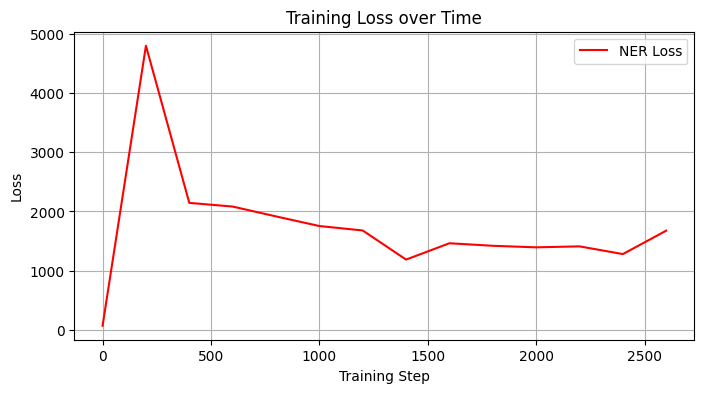

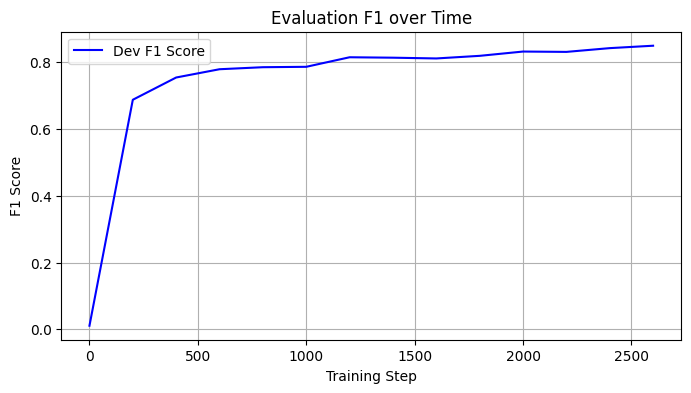

In [17]:
import json
import matplotlib.pyplot as plt

log_path = "/kaggle/working/training.log"
steps, losses, scores = [], [], []

with open(log_path, "r") as f:
    for line in f:
        rec = json.loads(line)
        if "step" in rec:
            steps.append(rec["step"])
            # Loss per pipe, e.g., rec["losses"]["ner"]
            losses.append(rec["losses"].get("ner", 0))
            scores.append(rec.get("score", 0))

# Plot loss
plt.figure(figsize=(8,4))
plt.plot(steps, losses, label="NER Loss", color="red")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.grid(True)
plt.legend()
plt.show()

# Plot evaluation score (F1)
plt.figure(figsize=(8,4))
plt.plot(steps, scores, label="Dev F1 Score", color="blue")
plt.xlabel("Training Step")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 over Time")
plt.grid(True)
plt.legend()
plt.show()